<a href="https://colab.research.google.com/github/nvasin/StockAdvisor/blob/main/EDAs/LEAS_EDA_2(%D0%BC%D0%B5%D0%BD%D1%8C%D1%88%D0%B5_%D0%B3%D0%BE%D0%B4%D0%B0).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
ticker = 'LEAS'
data = pd.read_csv(f'{ticker}_moex_10m_data.csv')

In [3]:
# import yfinance as yf


# start_date = '2022-03-01'
# end_date = '2024-11-01'
# data = yf.download('AAPL', start_date, end_date)

## Изучение структуры данных

In [4]:
data['Datetime'] = pd.to_datetime(data['Datetime'])
date_range = str(data['Datetime'].dt.date.min()) + ' to ' + str(data['Datetime'].dt.date.max())
date_range

'2024-03-29 to 2024-11-02'

In [5]:
data.set_index('Datetime', inplace = True)

In [6]:
data.head()

,Open,High,Low,Close,Volume,Ticker
Datetime,,,,,,
2024-03-29 15:00:00,1000.0,1000.0,1000.0,1000.0,183276.0,LEAS
2024-03-29 15:10:00,1000.1,1070.0,981.2,992.4,1986082.0,LEAS
2024-03-29 15:20:00,992.4,1000.0,985.0,990.0,634561.0,LEAS
2024-03-29 15:30:00,990.0,999.0,990.0,998.2,303334.0,LEAS
2024-03-29 15:40:00,998.2,999.7,990.4,993.6,258125.0,LEAS


In [7]:
data.isnull().sum()

,0
Open,0
High,0
Low,0
Close,0
Volume,0
Ticker,0


In [8]:
data.describe()

,Open,High,Low,Close,Volume
count,54710.000000,54710.000000,54710.000000,54710.000000,5.471000e+04
mean,827.896101,829.039262,826.463820,827.843519,3.375253e+03
std,146.090966,146.218659,145.924563,146.094514,1.148046e+04
min,577.700000,580.000000,577.000000,577.700000,1.000000e+00
25%,681.100000,682.000000,680.000000,681.000000,5.320000e+02
50%,851.150000,852.000000,850.000000,851.300000,1.421000e+03
75%,963.600000,965.000000,960.825000,963.600000,3.384500e+03
max,1059.300000,1070.000000,1057.500000,1059.300000,1.986082e+06


> Структура данных - OHLC.

> Данные с временным шагом 10 минут.

> За период 29.03.2024 - 02.11.2024.

> Пропуски отсутствуют.

## Первичная визуализация

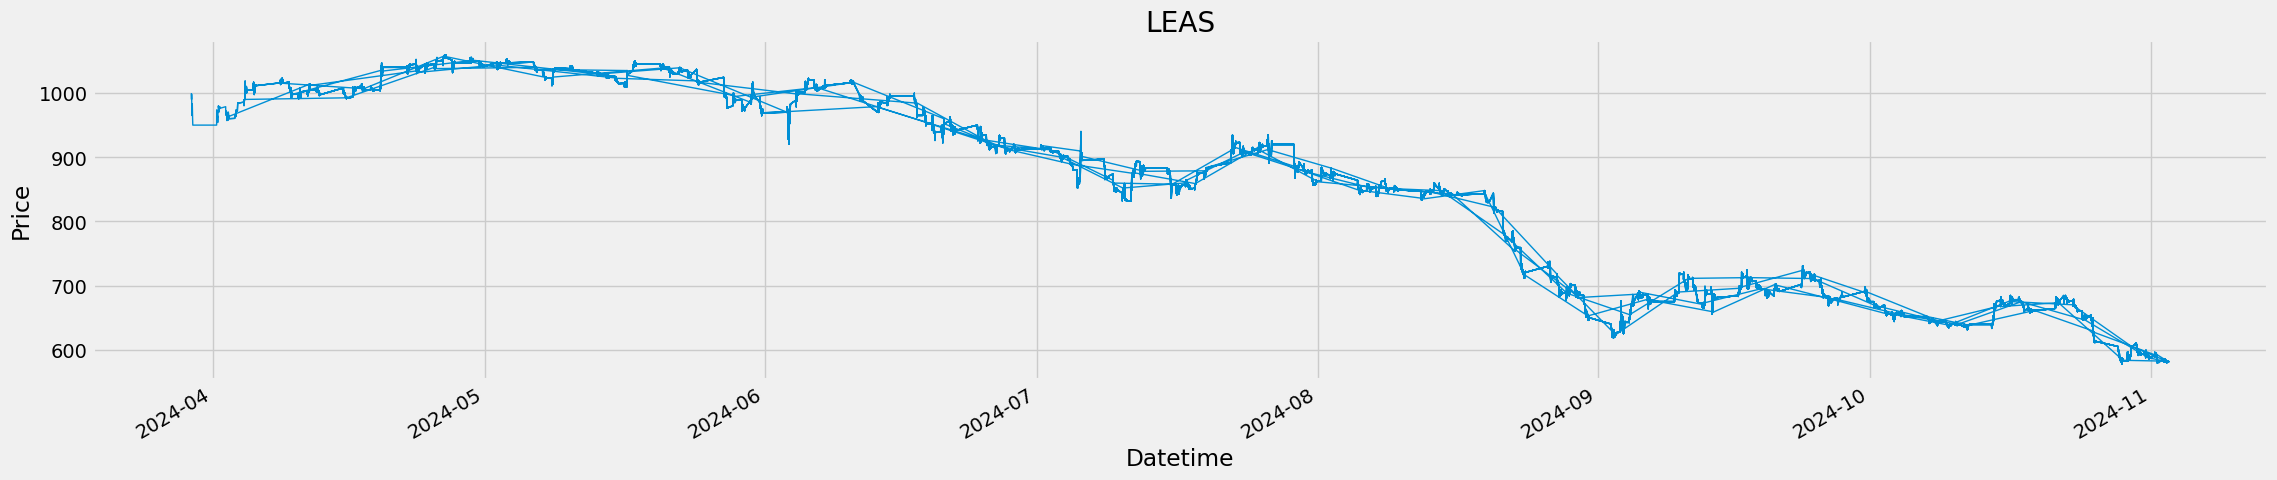

In [11]:
data['Close'].plot()
plt.title(ticker)
plt.ylabel("Price")
plt.rc("figure", figsize=(25,5))
plt.show()

array([<Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>, <Axes: xlabel='Datetime'>,
       <Axes: xlabel='Datetime'>], dtype=object)

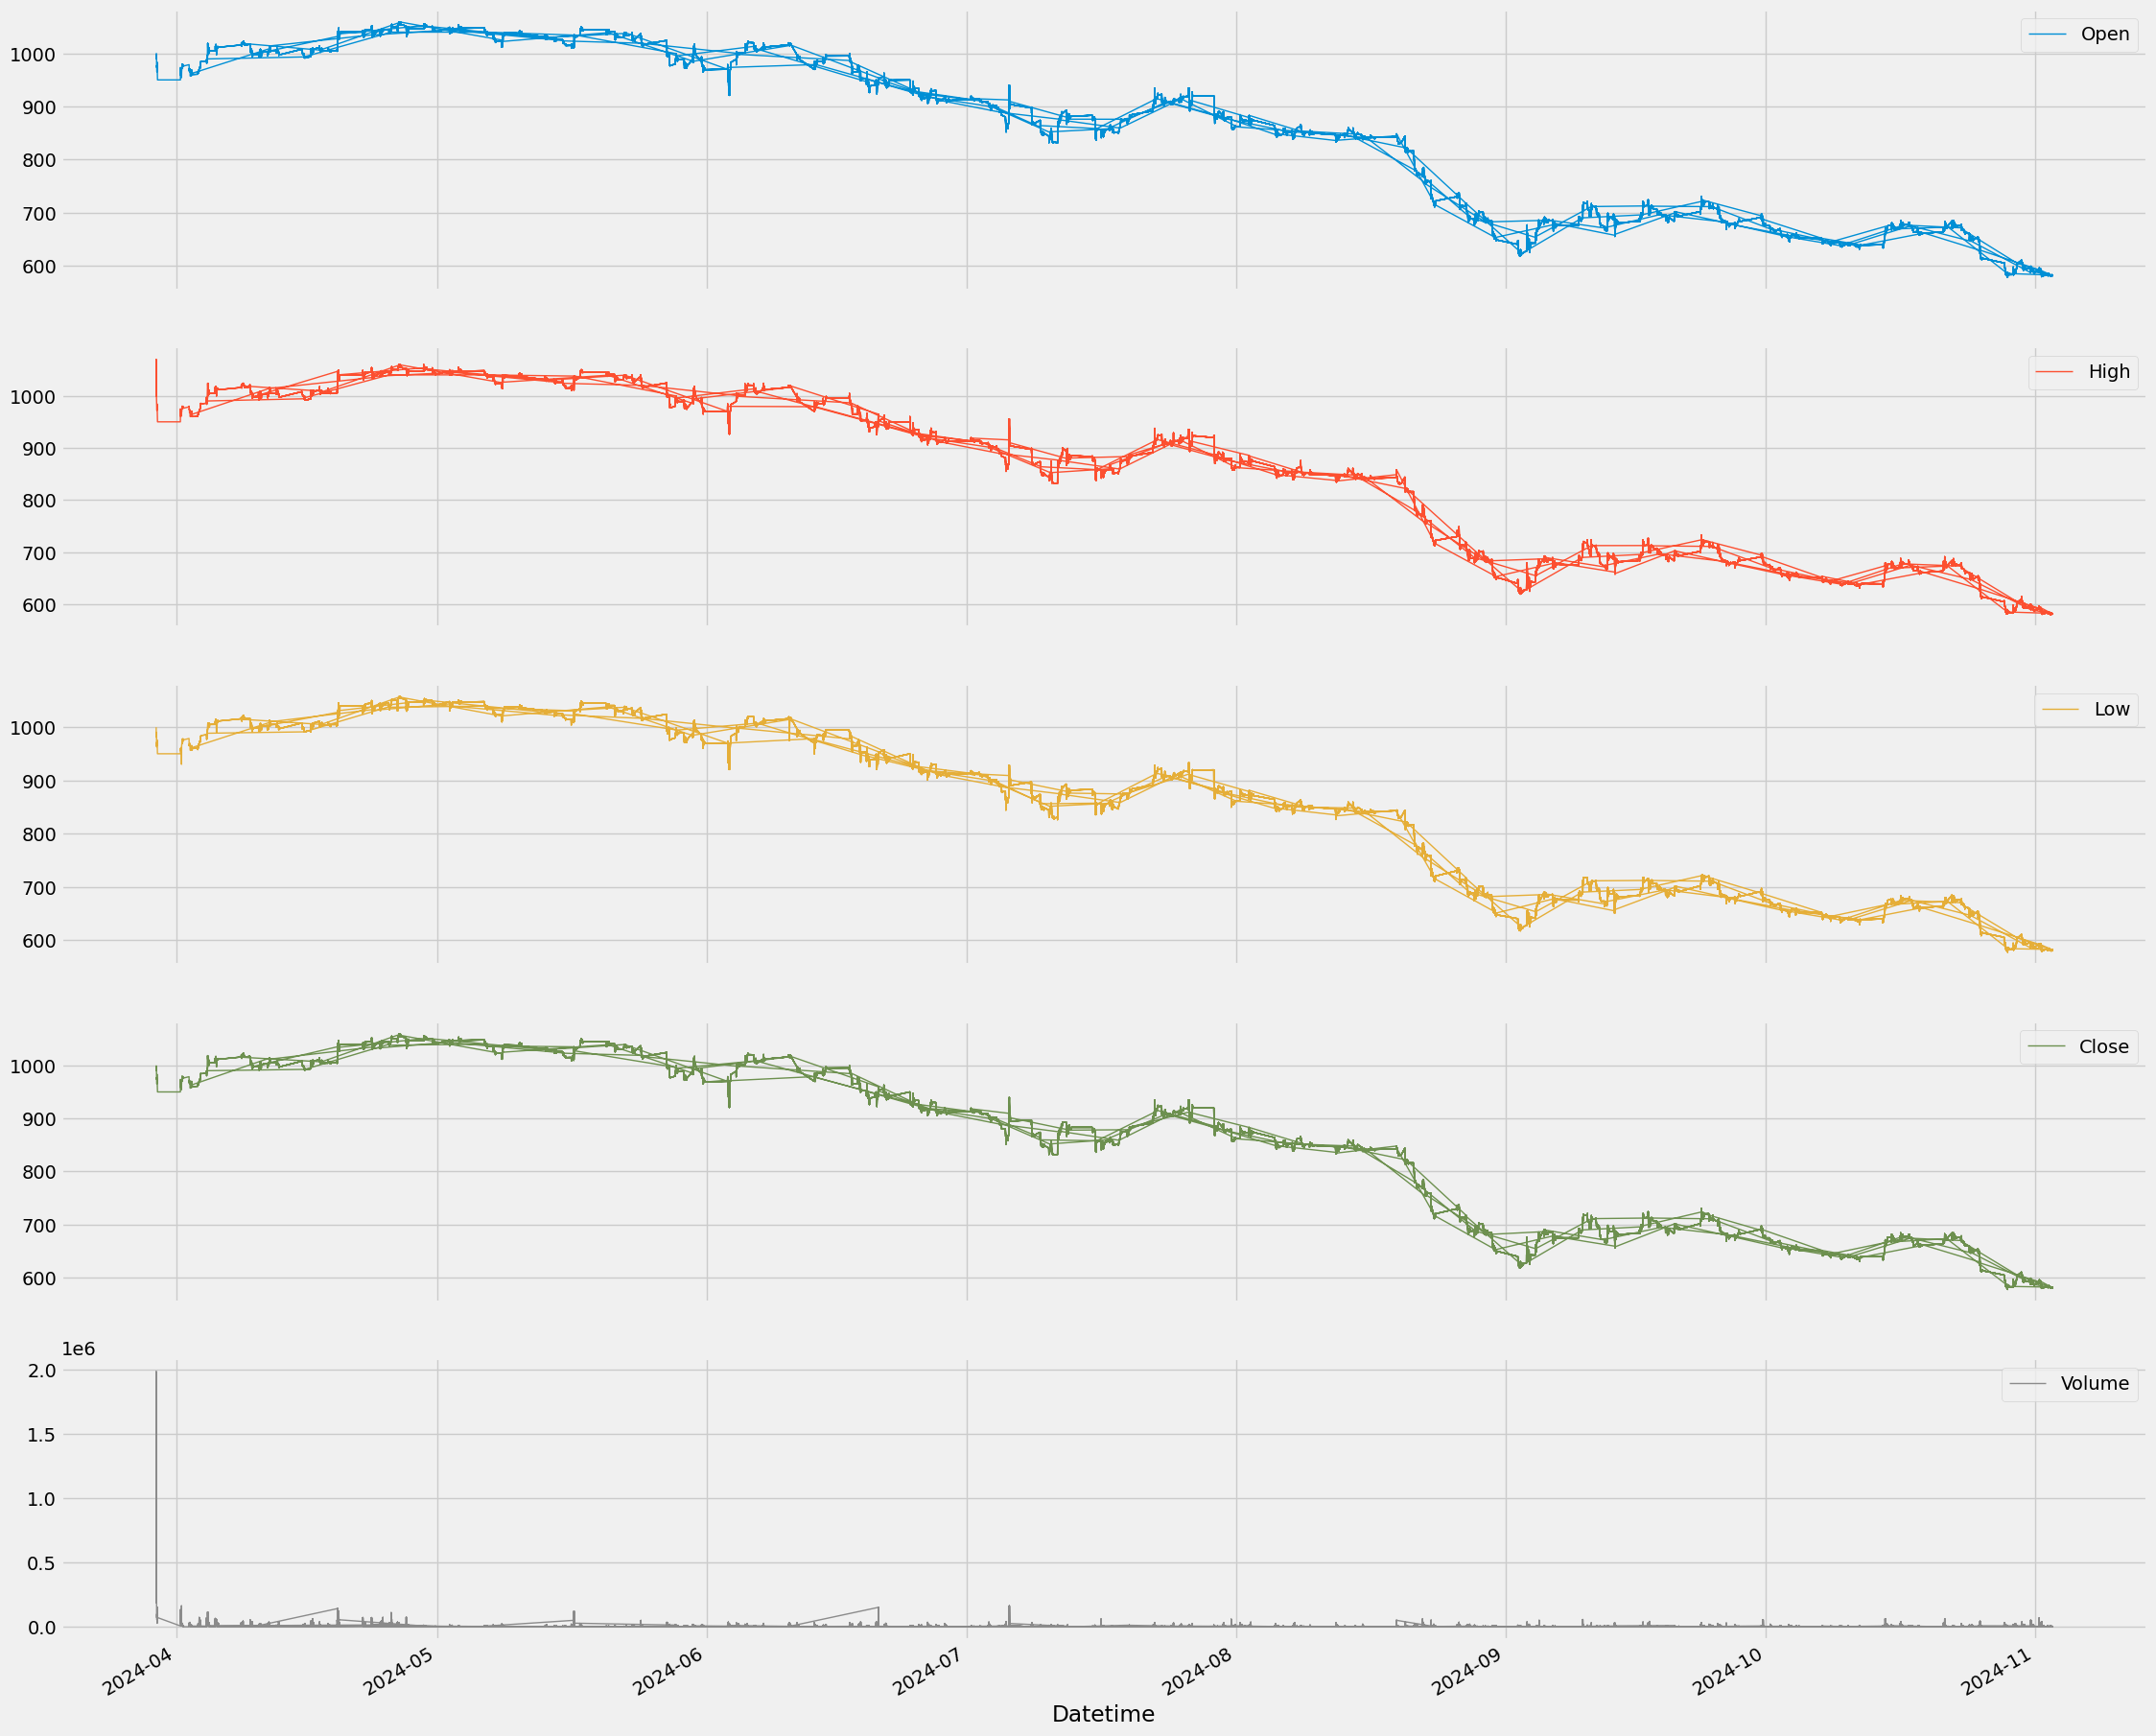

In [10]:
plt.style.use("fivethirtyeight")
plt.rcParams['lines.linewidth'] = 1
data.plot(subplots=True, figsize=(25, 25))

Text(0.5, 1.0, 'Resampled  - Month')

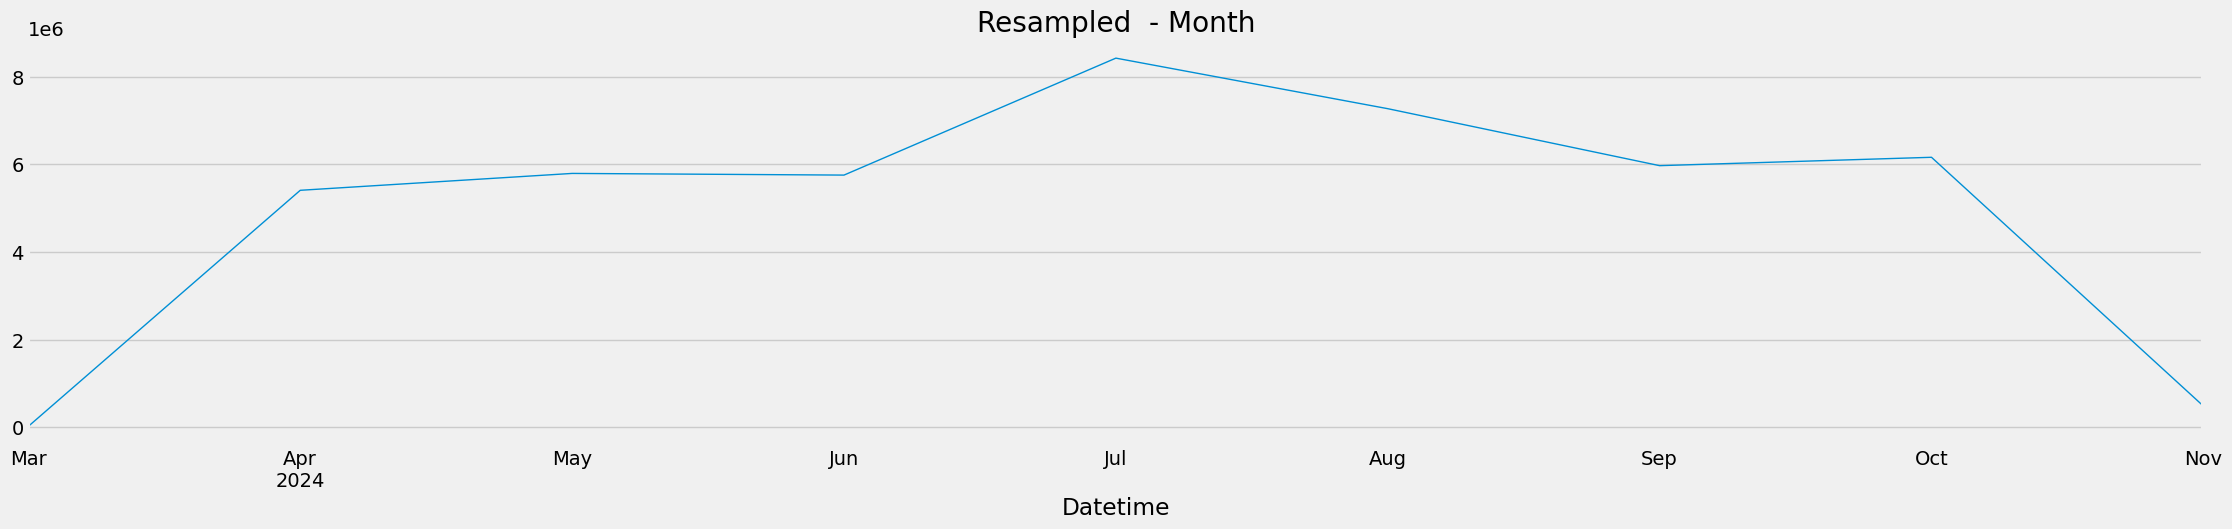

In [12]:
data['Close'].resample("ME").sum().plot()
plt.title('Resampled  - Month')

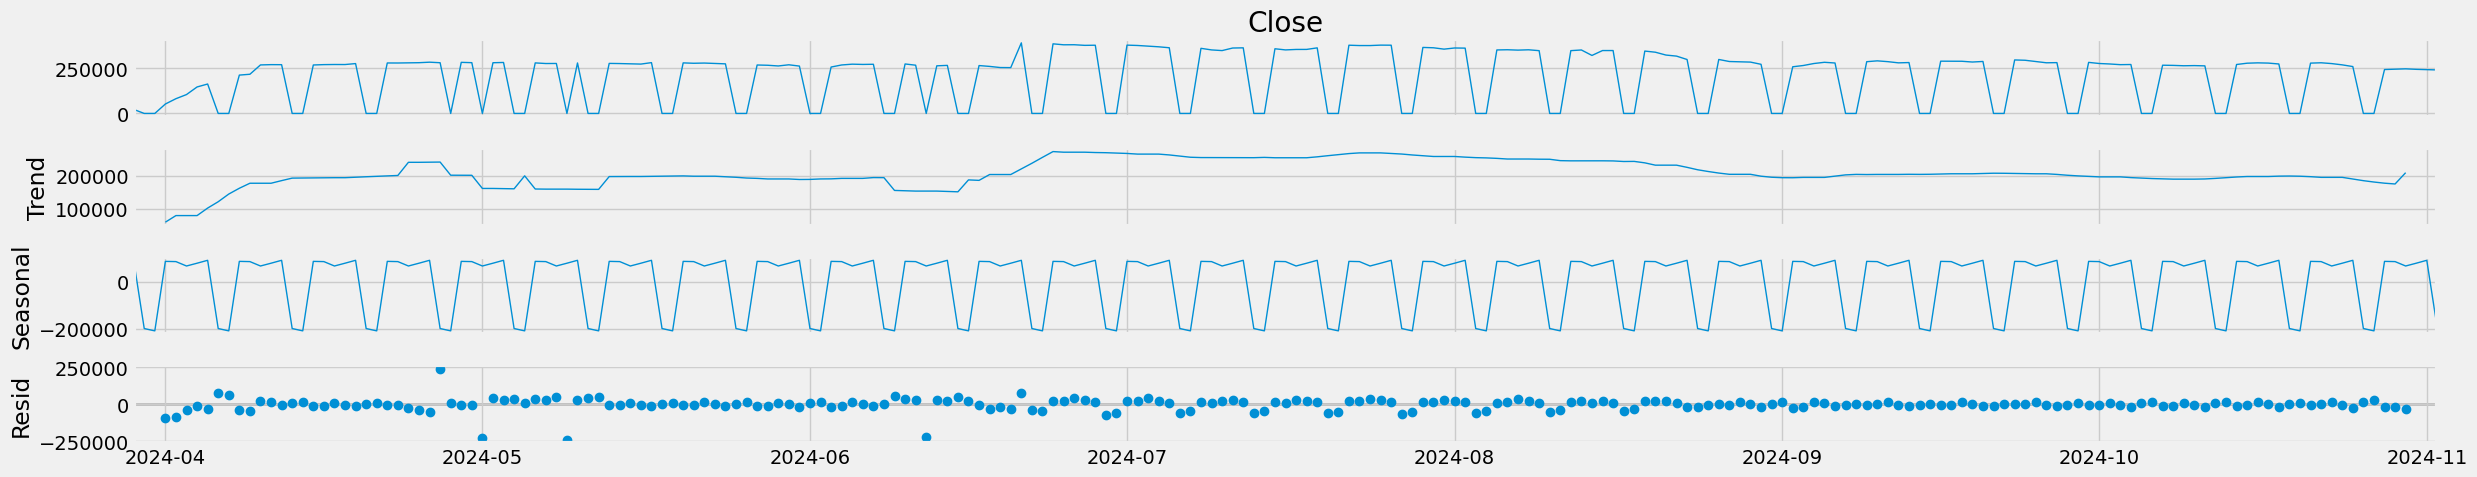

In [14]:
import statsmodels.api as sm


res = sm.tsa.seasonal_decompose(data['Close'].resample("D").sum())
resplot = res.plot()

> Сезонности нет.

## Статистические характеристики

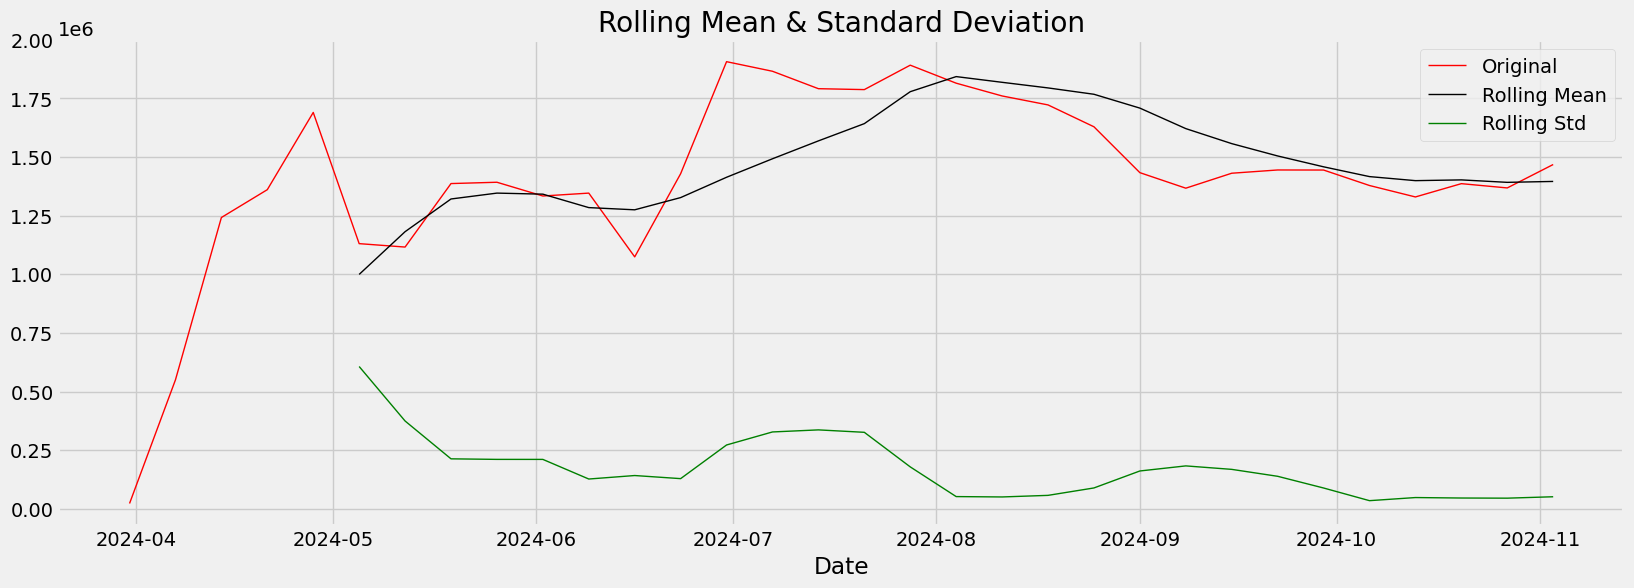

In [15]:
X = data['Close'].resample("W").sum()

rolmean = X.rolling(6).mean()
rolstd = X.rolling(6).std()

plt.figure(figsize=(18,6))
orig = plt.plot(X, color='red',label='Original')
mean = plt.plot(rolmean, color='black', label='Rolling Mean')
std = plt.plot(rolstd, color='green', label = 'Rolling Std')
plt.xlabel("Date")
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

> Нестационарный временной ряд.

## Специальные тесты TS

ADF

In [16]:
from statsmodels.tsa.stattools import adfuller


X = data['Close'].resample("W").sum().values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.729781
p-value: 0.415837


ACF

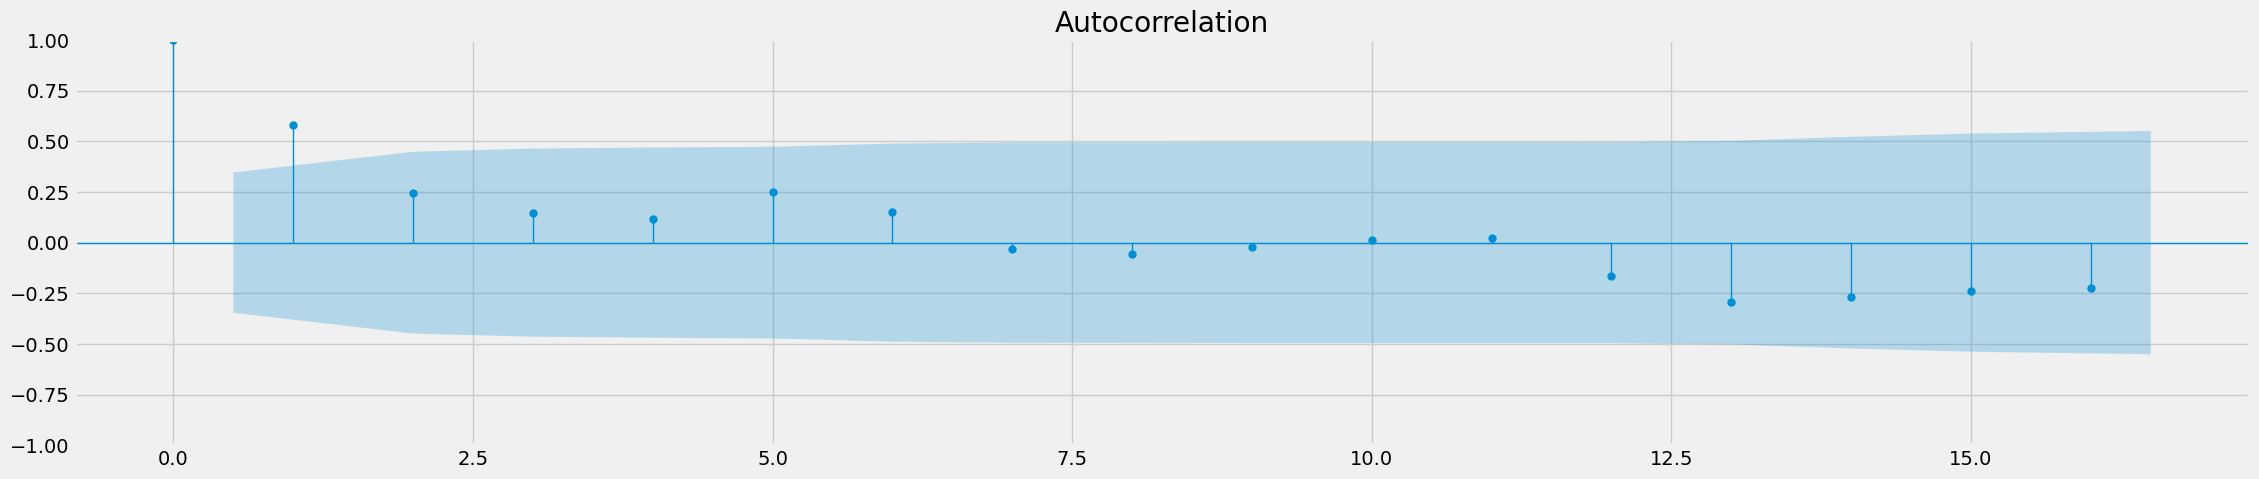

In [17]:
from statsmodels.graphics.tsaplots import plot_acf


plot_acf(X)
plt.show()

PACF

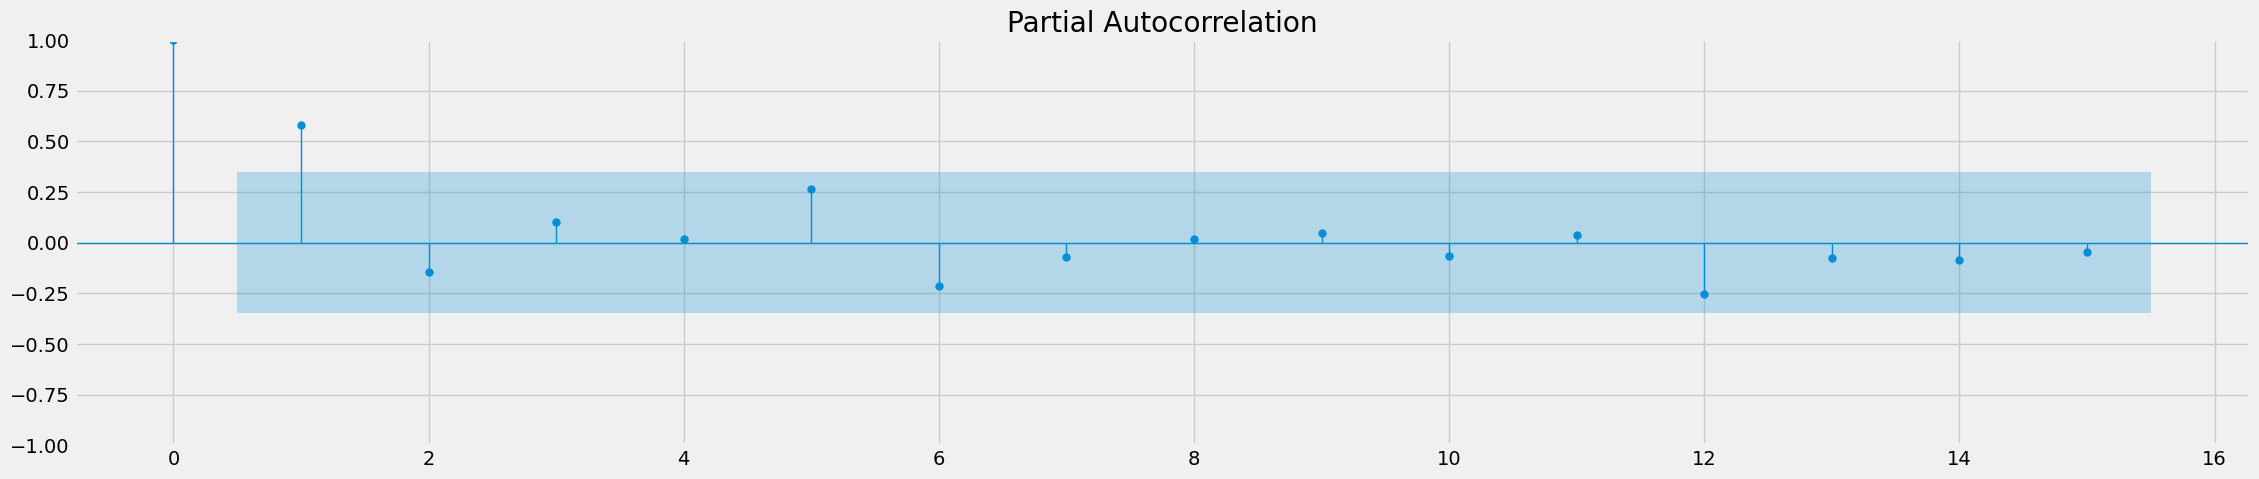

In [19]:
from statsmodels.graphics.tsaplots import plot_pacf


plot_pacf(X, lags=15)
plt.show()

## Дополнительно

In [20]:
data_2 = data.copy()

In [21]:
data_2['year'] = [x for x in data_2.index.year]
data_2['month'] = [x for x in data_2.index.month]
data_2 = data_2.reset_index()
data_2['week'] = data_2['Datetime'].apply(lambda x:x.week)
data_2 = data_2.set_index('Datetime')
data_2['hour'] = [x for x in data_2.index.hour]
data_2['day'] = [x for x in data_2.index.day_of_week]
data_2['day_str'] = [x.strftime('%a') for x in data_2.index]
data_2['year_month'] = [str(x.year) + '_' + str(x.month) for x in data_2.index]

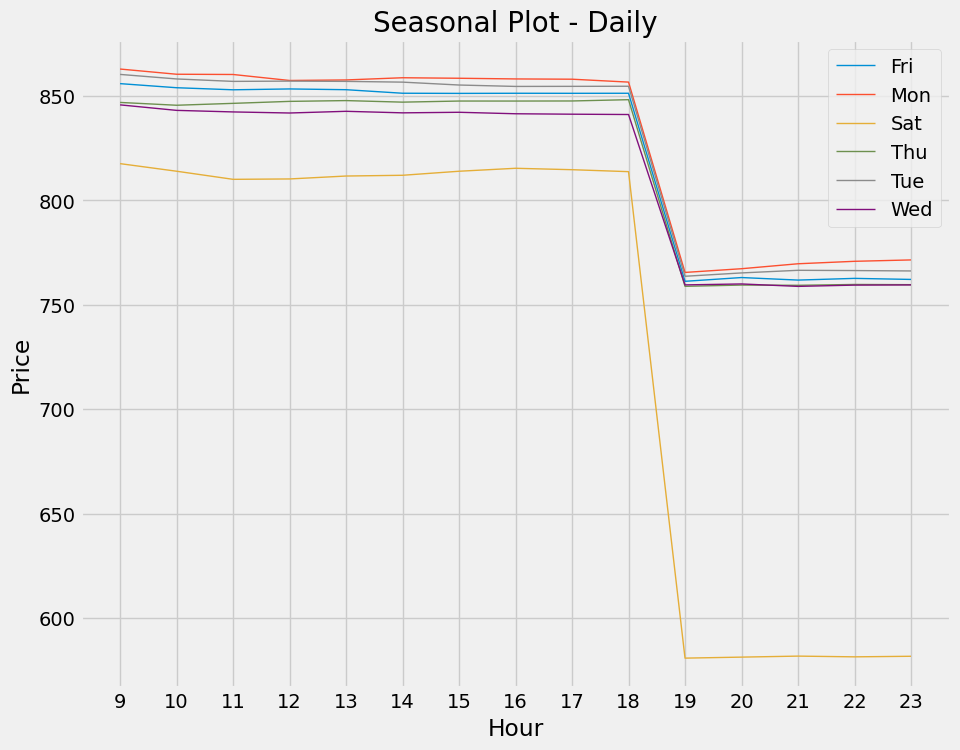

In [22]:
import seaborn as sns


df_plot = data_2[['hour', 'day_str', 'Close']].dropna().groupby(['hour', 'day_str']).mean()[['Close']].reset_index()

plt.figure(figsize=(10,8))
sns.lineplot(data = df_plot, x='hour', y='Close', hue='day_str', legend=True)
plt.locator_params(axis='x', nbins=24)
plt.title("Seasonal Plot - Daily", fontsize=20)
plt.ylabel('Price')
plt.xlabel('Hour')
plt.legend()

Text(0.5, 0, 'Year Month')

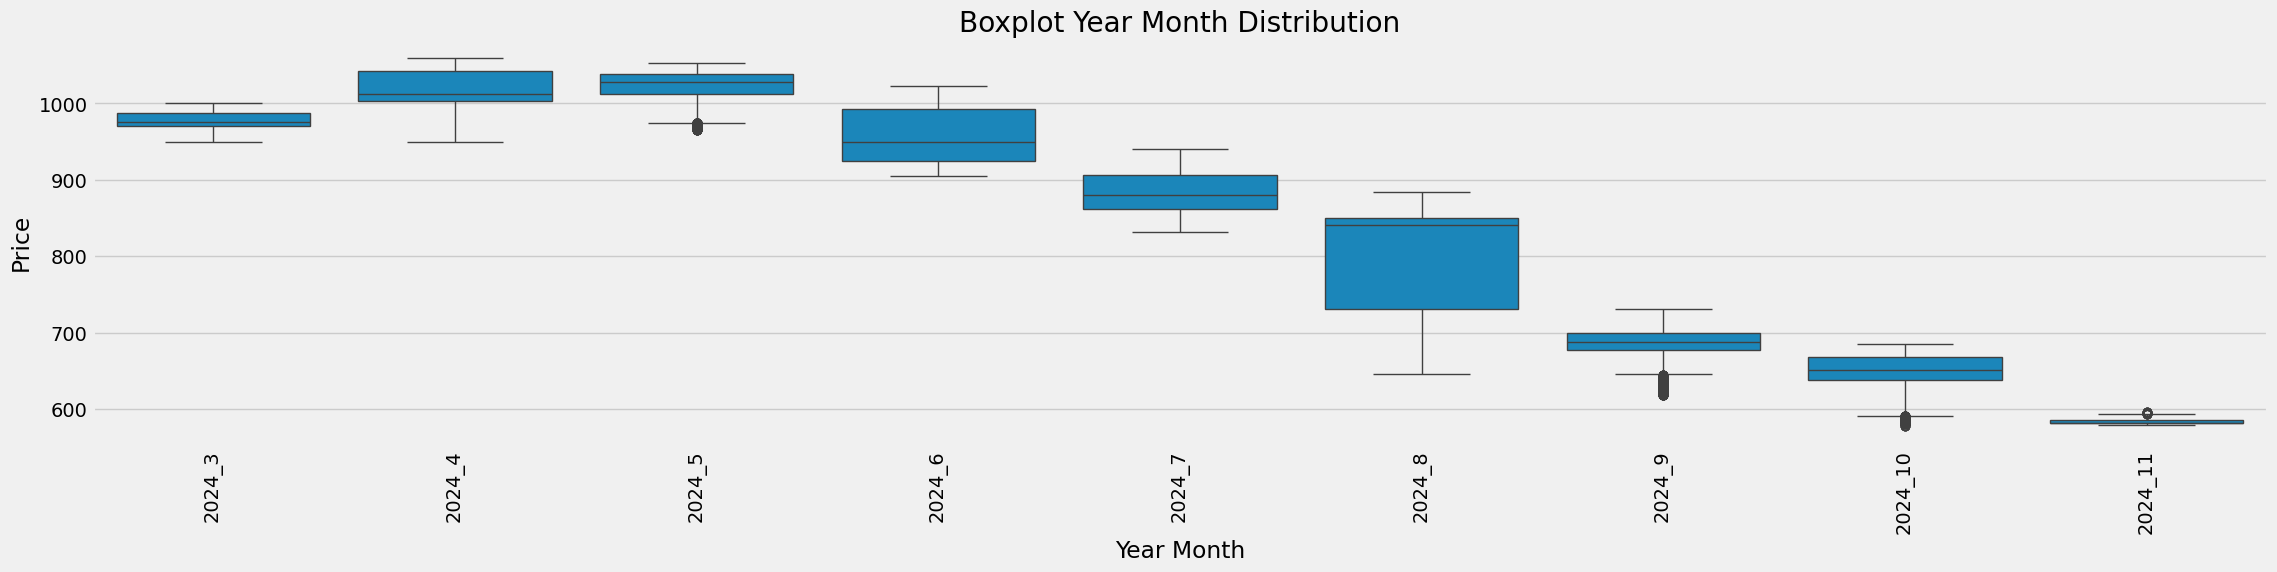

In [23]:
data_2['year'] = [x for x in data_2.index.year]
data_2['month'] = [x for x in data_2.index.month]
data_2['year_month'] = [str(x.year) + '_' + str(x.month) for x in data_2.index]

df_plot = data_2[data_2['year'] >= 2017].reset_index().sort_values(by='Datetime').set_index('Datetime')
plt.title(f'Boxplot Year Month Distribution');
plt.xticks(rotation=90)
plt.xlabel('Year Month')
plt.ylabel('MW')

sns.boxplot(x='year_month', y='Close', data=df_plot)
plt.ylabel('Price')
plt.xlabel('Year Month')